In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import sklearn
import pandas as pd
import scipy

from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from tqdm import tqdm_notebook as tqdmn

import seaborn as sns
import warnings
from PIL import Image

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from scipy.sparse import csr_matrix, isspmatrix, issparse

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#!/usr/bin/python
import os
import sys

import math
import matplotlib.image as mpimg
import numpy as np
import re

In [3]:
def get_test_statistics(true_vals,pred_vals):
    accuracy = np.sum(true_vals==pred_vals)/np.shape(pred_vals)[0]
    precision =  np.sum((true_vals==pred_vals)&(true_vals==1))/np.sum(pred_vals)
    recall =  np.sum((true_vals==pred_vals)&(true_vals==1))/np.sum(true_vals)
    f1 = 2*precision*recall/(precision+recall)
    print("Accuracy : %.3f"%(accuracy))
    print("Precision : %.3f"%(precision))
    print("Recall : %.3f"%(recall))
    print("F1-Score : %.3f"%(f1))
    print("Confusion Matrix")
    return( pd.crosstab(true_vals, pred_vals, 
                       rownames=['True'], colnames=['Predicted'], margins=True))

In [4]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [5]:
# Loaded a set of images
root_dir = "zip2/"

image_dir = root_dir + "training/images/"
files = os.listdir(image_dir)
n =len(files) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "training/groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[1])
imgs[4]
n = 10 # Only use 10 images for training
files


Loading 100 images
satImage_069.png
Loading 100 images
satImage_065.png


['satImage_069.png',
 'satImage_065.png',
 'satImage_091.png',
 'satImage_063.png',
 'satImage_018.png',
 'satImage_077.png',
 'satImage_027.png',
 'satImage_090.png',
 'satImage_008.png',
 'satImage_053.png',
 'satImage_064.png',
 'satImage_079.png',
 'satImage_030.png',
 'satImage_094.png',
 'satImage_061.png',
 'satImage_039.png',
 'satImage_006.png',
 'satImage_093.png',
 'satImage_092.png',
 'satImage_074.png',
 'satImage_072.png',
 'satImage_075.png',
 'satImage_022.png',
 'satImage_100.png',
 'satImage_019.png',
 'satImage_041.png',
 'satImage_088.png',
 'satImage_020.png',
 'satImage_084.png',
 'satImage_001.png',
 'satImage_049.png',
 'satImage_050.png',
 'satImage_035.png',
 'satImage_096.png',
 'satImage_038.png',
 'satImage_044.png',
 'satImage_057.png',
 'satImage_015.png',
 'satImage_051.png',
 'satImage_033.png',
 'satImage_031.png',
 'satImage_095.png',
 'satImage_070.png',
 'satImage_080.png',
 'satImage_032.png',
 'satImage_021.png',
 'satImage_045.png',
 'satImage_00

In [6]:
files[0]

'satImage_069.png'

In [7]:
import os
test_dir = "zip1/"
test_dir_images = test_dir + "test_set_images/"
test_img = []
for i in range(50):
    j = i+1
    help_dir = test_dir_images + "test_"+'%.1d' % j + "/"
    help_files = os.listdir(help_dir)
    test_img.append(help_dir + help_files[0])

 


In [8]:
n = len(test_img)
print("Loading " + str(n) + " images")
gt_imgs1 = [load_image(test_img[i]) for i in range(n)]

Loading 50 images


In [9]:
print(gt_imgs1[0])

[[[0.2        0.18039216 0.16862746]
  [0.18431373 0.16862746 0.15686275]
  [0.23137255 0.2        0.18431373]
  ...
  [0.4745098  0.45882353 0.43137255]
  [0.5647059  0.54901963 0.5137255 ]
  [0.5411765  0.5294118  0.49411765]]

 [[0.22352941 0.2        0.18431373]
  [0.19607843 0.1764706  0.16470589]
  [0.21960784 0.19215687 0.1764706 ]
  ...
  [0.28235295 0.27058825 0.25490198]
  [0.5568628  0.5372549  0.5019608 ]
  [0.54901963 0.53333336 0.49803922]]

 [[0.23137255 0.21568628 0.2       ]
  [0.22352941 0.19607843 0.18039216]
  [0.21176471 0.18431373 0.17254902]
  ...
  [0.5411765  0.52156866 0.4862745 ]
  [0.5294118  0.5058824  0.4627451 ]
  [0.5254902  0.5019608  0.45882353]]

 ...

 [[0.5176471  0.49411765 0.44705883]
  [0.54509807 0.5254902  0.48235294]
  [0.54901963 0.5254902  0.48235294]
  ...
  [0.30980393 0.3254902  0.3019608 ]
  [0.3137255  0.32156864 0.3019608 ]
  [0.32941177 0.34117648 0.32156864]]

 [[0.5019608  0.47843137 0.43137255]
  [0.56078434 0.5411765  0.49803922]


Image size = 400,400


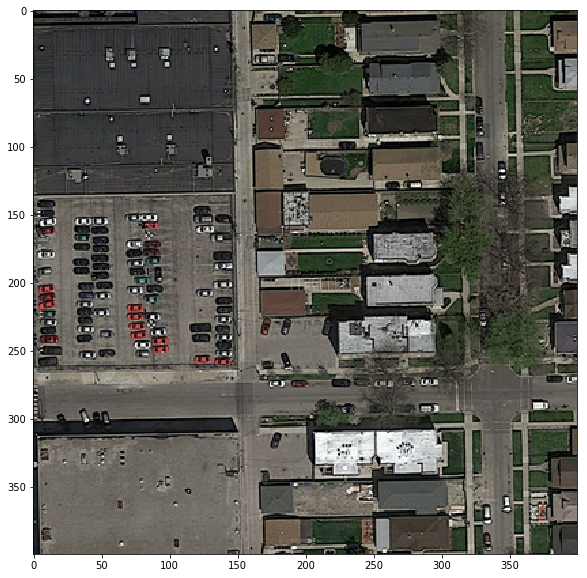

In [11]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')
plt.imshow(imgs[10])

In [12]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [17]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

def extract_features_2d_patch(filename, i):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    feat_m = np.mean(img_patches[i])
    feat_v = np.var(img_patches[i])
    feat = np.append(feat_m, feat_v)
    if i%25!=24:
        n_r = extract_features_2d(img_patches[i+1])
        feat = np.append(feat,n_r)
        feat = np.append(feat,"right")
    if i%25!=0:
        n_l = extract_features_2d(img_patches[i-1])
        feat = np.append(feat,n_l)
        feat = np.append(feat,"left")
    if i>24:
        n_u = extract_features_2d(img_patches[i-25])
        feat = np.append(feat,n_u)
        feat = np.append(feat,"up")
    if i<600:
        n_d = extract_features_2d(img_patches[i+25])
        feat = np.append(feat, n_d)
        feat = np.append(feat,"down")
    if (i%25!=0)&(i>24):
        n_1 = extract_features_2d(img_patches[i-26])
        feat = np.append(feat, n_1)
        feat = np.append(feat,"up left")
    if (i%25!=24)&(i>24):
        n_2 = extract_features_2d(img_patches[i-24])
        feat = np.append(feat, n_2)
        feat = np.append(feat,"up right")
    if (i%25!=0)&(i<600):
        n_3 = extract_features_2d(img_patches[i+24])
        feat = np.append(feat, n_3)
        feat = np.append(feat,"left down")
    if (i%25!=24)&(i<600):
        n_4 = extract_features_2d(img_patches[i+26])
        feat = np.append(feat, n_4)
        feat = np.append(feat,"right down")
    
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d_patch(filename, i) for i in range(len(img_patches))])
    return X

In [18]:
extract_features_2d_patch(image_dir + files[0], 105)

array(['0.2203023', '0.0041463207', '0.21394508', '0.0057504247', 'right',
       '0.21457823', '0.0099471295', 'left', '0.21253066', '0.009976026',
       'up', '0.24071182', '0.0028552965', 'down', '0.23557496',
       '0.008252698', 'up left', '0.2494179', '0.019132188', 'up right',
       '0.14173818', '0.0043128897', 'left down', '0.2601767',
       '0.0040115095', 'right down'], dtype='<U32')

In [21]:
a = extract_img_features(image_dir + files[0])

In [24]:
a

array([array(['0.2757302', '0.071881704', '0.88719875', '0.0024697296', 'right',
       '0.31304127', '0.08564737', 'down', '0.8814849', '0.010597293',
       'right down'], dtype='<U32'),
       array(['0.88719875', '0.0024697296', '0.85612744', '0.022391448', 'right',
       '0.2757302', '0.071881704', 'left', '0.8814849', '0.010597293',
       'down', '0.31304127', '0.08564737', 'left down', '0.85047483',
       '0.031307872', 'right down'], dtype='<U32'),
       array(['0.85612744', '0.022391448', '0.90663296', '0.0022390196', 'right',
       '0.88719875', '0.0024697296', 'left', '0.85047483', '0.031307872',
       'down', '0.8814849', '0.010597293', 'left down', '0.90613765',
       '0.0013492554', 'right down'], dtype='<U32'),
       array(['0.90663296', '0.0022390196', '0.89861625', '0.005382672', 'right',
       '0.85612744', '0.022391448', 'left', '0.90613765', '0.0013492554',
       'down', '0.85047483', '0.031307872', 'left down', '0.8865605',
       '0.016085679', 'right do

In [ ]:
def spiral(img, j, l):
    img_patches = img_crop(img, patch_size, patch_size)
    starting_patch = img_patches[j]
    spiral_img = []
    spiral_img.append(starting_patch)
    used_indices = []
    used_indices.append(j)
    for i in range(l):
        if (0<=j<400):
            if (j%4==1):
                if(j<600):
                    j = j+25
                    if j not in used_indices:
                        spiral_img.append(img_patches[j])
                        used_indices.append(j)
                    else:
                        if(j%25!=0):
                            j = j-1
                            spiral_img.append(img_patches[j])
                            used_indices.append(j)
                
            elif (j%4==2):
                if(j%25!=24):
                    j = j+1
                    if j not in used_indices:
                         spiral_img.append(img_patches[j])
                         used_indices.append(j)
                    else: 
                        if(j<600):
                            j = j+25
                            spiral_img.append(img_patches[j])
                            used_indices.append(j)
            elif j%4==3:
                if(j>24):
                    j = j-25
                    if j not in used_indices:
                        spiral_img.append(img_patches[j])                                     
                        used_indices.append(j)
                    else: 
                        if(j%25!=24):
                            j = j+1
                            spiral_img.append(img_patches[j])
                            used_indices.append(j)
            elif (j%4==0):
                if(j%25!=0):
                    j = j-1
                    if j not in used_indices:
                        spiral_img.append(img_patches[j])
                        used_indices.append(j)
                    else:  
                        if(j<600):
                            j = j+25
                            spiral_img.append(img_patches[j])
                            used_indices.append(j)
        i = i+1        
    return spiral_img
        
        
        
    
    

In [ ]:
patch_size = 16

In [ ]:
u = spiral(gt_imgs1[0],100, 20)

In [ ]:
len(u[0][0])
 

In [ ]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
filenames = []
for i in range(100):
    filenames.append(image_dir + files[i])
for j in range(100):
    X = []
    X = [extract_features_2d_patch(filenames[j], i) for i in range(625)]
    
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [ ]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

In [ ]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

In [ ]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

In [ ]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

In [ ]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [ ]:
# Run prediction on the img_idx-th image
img_idx = 10

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
h



In [ ]:
# Random forest classifier

In [ ]:
nb_samples = 80
n_estimators_set = np.random.randint(low=30,high=100,size=nb_samples)
max_depth_set = np.random.randint(low=15,high=50,size=nb_samples)

In [ ]:
#RF Models hyperparameters will be optimized according to the f1-score of the positive class 
def rf_model_train(X_train,y_train,X_test,y_test,model,cv=5):
    X_train, X_test = X_train.copy(),X_test.copy()
    y_train, y_test = y_train.copy(),y_test.copy()
    nb_samples,_ = X_train.shape
    res = []
    for cv_idx in range(cv):
        idx_val = list(range(cv_idx*nb_samples//cv,(cv_idx+1)*nb_samples//cv))
        idx_train = list(set(range(nb_samples))-set(idx_val))
        X_cv_train,y_cv_train = X_train.iloc[idx_train], y_train.iloc[idx_train]
        X_cv_val,y_cv_val = X_train.iloc[idx_val], y_train.iloc[idx_val]
        y_cv_true = np.array(y_cv_val).ravel()
        y_cv_pred = model.fit(X_cv_train,y_cv_train).predict(X_cv_val)
        res.append(np.sum(y_cv_true==y_cv_pred)/np.shape(y_cv_pred)[0])
    res_mean = np.array(res).mean()
    res_std = np.array(res).std()
    return res_mean

In [ ]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,
                                                random_state=0)

In [ ]:
Xtrain_df =pd.DataFrame(Xtrain)
Xtest_df =pd.DataFrame(Xtest)
ytrain_df =pd.DataFrame(ytrain)
ytest_df =pd.DataFrame(ytest)

In [ ]:

Xtrain_df_norm = (Xtrain_df-Xtrain_df.mean())/Xtrain_df.std()
Xtest_df_norm = (Xtest_df-Xtest_df.mean())/Xtest_df.std()


In [ ]:
# Automatize parameter search and return best scoring parameter (score chosen accuracy for positive class)
def grid_search_model(X_train_df,y_train_df,X_test_df,y_test_df,
                      n_estimators_set,max_depth_set):
    final_rf_res = {(est,dep): rf_model_train(Xtrain_df_norm,ytrain_df,Xtest_df_norm,ytest_df,
                                   RFC(n_estimators = est,max_depth = dep, n_jobs=-1))
                    for est,dep in tqdmn(zip(n_estimators_set,max_depth_set))}
    best_params_id = np.argmax(np.array(final_rf_res.values()))
    return list(final_rf_res.keys())[best_params_id],list(final_rf_res.values())[best_params_id]


RF_best_params, RF_best_score = grid_search_model(Xtrain_df_norm,ytrain_df,
                                                  Xtest_df_norm,ytest_df,
                                                  n_estimators_set,max_depth_set)

In [ ]:

print("Best Params: \nMax depth %d, Nb estimators %d with 5-fold val-accuracy at %.3f"%(RF_best_params[0],
                                                      RF_best_params[1],RF_best_score))


In [ ]:

full_pred = RFC(n_estimators = RF_best_params[0],
                max_depth = RF_best_params[1]).fit(Xtrain_df_norm,ytrain_df)\
            .predict(Xtest_df_norm)
len(set(np.where(full_pred==0)[0]))

In [ ]:
def get_test_statistics(true_vals,pred_vals):
    accuracy = np.sum(true_vals==pred_vals)/np.shape(pred_vals)[0]
    precision =  np.sum((true_vals==pred_vals)&(true_vals==1))/np.sum(pred_vals)
    recall =  np.sum((true_vals==pred_vals)&(true_vals==1))/np.sum(true_vals)
    f1 = 2*precision*recall/(precision+recall)
    print("Accuracy : %.3f"%(accuracy))
    print("Precision : %.3f"%(precision))
    print("Recall : %.3f"%(recall))
    print("F1-Score : %.3f"%(f1))
    print("Confusion Matrix")
    return( pd.crosstab(true_vals, pred_vals, 
                       rownames=['True'], colnames=['Predicted']))

In [ ]:
y_test_df = ytest_df.values.ravel()

In [ ]:
print("Results for Negative Class")
get_test_statistics(1-y_test_df,1-full_pred)

In [ ]:
print("Results for Positive class")
get_test_statistics(y_test_df,full_pred)

In [ ]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, full_pred)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
plt.imshow(predicted_im)


In [ ]:
plt.imshow(new_img)

In [ ]:
def prec_ets(n_trees, X_train, y_train, X_test, y_test, random_state=None):
    """
    ExtraTrees
    """
    from sklearn.ensemble import ExtraTreesClassifier
    if not issparse(X_train):
        X_train = X_train.reshape((X_train.shape[0], -1))
    if not issparse(X_test):
        X_test = X_test.reshape((X_test.shape[0], -1))
  
    clf = ExtraTreesClassifier(n_estimators=n_trees, max_depth=None, n_jobs=-1, verbose=1, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    prec = float(np.sum(y_pred == y_test)) / len(y_test)
   
    return clf, y_pred 

In [ ]:
Xtrain_df =pd.DataFrame(Xtrain)
Xtest_df =pd.DataFrame(Xtest)
ytrain_df =pd.DataFrame(ytrain)
ytest_df =pd.DataFrame(ytest)

Xtrain_norm = (Xtrain-Xtrain.mean())/Xtrain.std()
Xtest_norm = (Xtest-Xtest.mean())/Xtest.std()

In [ ]:
a, b = prec_ets(500, Xtrain_norm, ytrain, Xtest_norm, ytest, random_state=None)


In [ ]:
a

In [ ]:
len(np.where(b==0)[0])

In [ ]:
len(b)

In [ ]:
print("Results for Positive class")
get_test_statistics(y_test_df,b)

In [ ]:
print("Results for Negative Class")
get_test_statistics(1-y_test_df,1-b)

In [ ]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, b)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
plt.imshow(predicted_im)


In [ ]:
plt.imshow(predicted_im)
plt.imshow(new_img)

In [ ]:
np.where(full_pred==0)
np.where(full_pred==1)
full_pred.shape

In [ ]:
def niblack_threshold(patch):
    patch_mean = np.mean(patch)
    patch_std = np.std(patch)
    threshold = patch_mean + 0.5*patch_std
    return threshold

In [ ]:

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch, threshold):
    df = np.mean(patch)
    if df > threshold:
        return 1
    else:
        return 0

def niblack_patch_to_label(patch, image):
    df = np.mean(patch)
    if df > niblack_threshold(image):
        return 1
    else:
        return 0    
    
def iterative_threshold(im, patch_size, T, tolerance):
    label1 = []
    label0 = []
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, T)
            if label==1:
                label1.append(label)
                else:
                label0.append(label)
    mean1 = np.mean(label1)
    mean0 = np.mean(label0)
    T1 = 0.5/(mean1+mean2)
    if np.absolute(T-T1)<tolerance:
        return T1
    else:
        iterative_threshold(im, patch_size, T, tolerance)
            
            


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = niblack_patch_to_label(patch, im)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


if __name__ == '__main__':
    submission_filename = 'dummy_submission.csv'
    masks_to_submission(submission_filename, *test_img)

In [ ]:
def patch_to_label(patch, threshold):
    df = np.mean(patch)
    if df > threshold:
        return 1
    else:
        return 0

In [ ]:
def iterative_threshold(im, patch_size, T, tolerance):
    label1 = []
    label0 = []
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, T)
            if label==1:
                label1.append(np.mean(patch))
            else:
                label0.append(np.mean(patch))
    if len(label1)>0:
        mean1 = np.mean(label1)
    else:
        mean1=0
    if len(label0)>0:
        mean0 = np.mean(label0)
    else:
        mean0=0
    T1 = 0.5*(mean1+mean0)
    if np.absolute(T-T1)<tolerance:
        return T1 
    else:
        return iterative_threshold(im, patch_size, T1, tolerance)

In [ ]:
imgs
files
image_dir + files[1]

In [ ]:
patch_size = 16
th = []
for i in range(len(files)):
    im = mpimg.imread(image_dir + files[i])
    th.append(iterative_threshold(im, patch_size, 0.5, 0.0001))

In [ ]:
import re


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, iterative_threshold(im, patch_size, 0.5, 0.0001))
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


if __name__ == '__main__':
    submission_filename = 'dummy_submission.csv'
    masks_to_submission(submission_filename, *test_img)

In [ ]:
import re


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    it = iterative_threshold(im, patch_size, 0.5, 0.1)
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, it)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))

In [ ]:

def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


In [ ]:


if __name__ == '__main__':
    submission_filename = 'dummy_submission.csv'
    masks_to_submission(submission_filename, *test_img)

In [ ]:
mask_to_submission_strings('training/training/groundtruth/satImage_001.png')

In [ ]:
dummy = pd.read_csv('dummy_submission.csv')

In [ ]:
dummy.head(100)


In [ ]:

label_file = 'dummy_submission.csv'

h = 16
w = h
imgwidth = int(math.ceil((600.0/w))*w)
imgheight = int(math.ceil((600.0/h))*h)
nc = 3

# Convert an array of binary labels to a uint8
def binary_to_uint8(img):
    rimg = (img * 255).round().astype(np.uint8)
    return rimg

def reconstruct_from_labels(image_id):
    im = np.zeros((imgwidth, imgheight), dtype=np.uint8)
    f = open(label_file)
    lines = f.readlines()
    image_id_str = '%.3d_' % image_id
    for i in range(1, len(lines)):
        line = lines[i]
        if not image_id_str in line:
            continue

        tokens = line.split(',')
        id = tokens[0]
        prediction = int(tokens[1])
        tokens = id.split('_')
        i = int(tokens[1])
        j = int(tokens[2])

        je = min(j+w, imgwidth)
        ie = min(i+h, imgheight)
        if prediction == 0:
            adata = np.zeros((w,h))
        else:
            adata = np.ones((w,h))

        im[j:je, i:ie] = binary_to_uint8(adata)

    Image.fromarray(im).save('prediction_' + '%.3d' % image_id + '.png')

    return im

for i in range(1, 5):
    reconstruct_from_labels(i)

In [ ]:
reconstruct_from_labels()

In [ ]:
image = imgs[2]
binary_global = image > threshold_otsu(image)

window_size = 25
thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
thresh_sauvola = threshold_sauvola(image, window_size=window_size)

binary_niblack = image > thresh_niblack
binary_sauvola = image > thresh_sauvola

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola, cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()